#### TODOS

- check that the forward pass of the dropout model is implemented correctly (there is something called inverse dropout and some weird scaling) incearca cele doua noi
- verifica ca la lenet + shift chiar e ok valuarea aia si nu ai stricat tu ceva e prea mica. 

#### Introduction

In [1]:

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from torch.nn.functional import conv2d, max_pool2d, cross_entropy

plt.rc("figure", dpi=100)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = 'cpu'
print(device)

cpu


In [2]:
TRAIN_BASE_MODEL = False
TRAIN_DROPOUT_MODEL = True
TRAIN_PRELU_MODEL = False
TRAIN_LENET = False
TRAIN_LENET_SHIFT = False

ALL = TRAIN_BASE_MODEL and TRAIN_DROPOUT_MODEL and TRAIN_PRELU_MODEL and TRAIN_LENET and TRAIN_LENET_SHIFT

In [3]:
n_epochs = 20
batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

transform_extended = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
]) 

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transform,
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [4]:
def init_weights(shape):
    # Kaiming He initialization (a good initialization is important)
    # https://arxiv.org/abs/1502.01852
    std = np.sqrt(2. / shape[0])
    w = torch.randn(size=shape).to(device) * std
    w.requires_grad = True
    return w


def rectify(x):
    # Rectified Linear Unit (ReLU)
    return torch.max(torch.zeros_like(x), x)


In [5]:
class RMSprop(optim.Optimizer):
    """
    This is a reduced version of the PyTorch internal RMSprop optimizer
    It serves here as an example
    """
    def __init__(self, params, lr=1e-3, alpha=0.5, eps=1e-8):
        defaults = dict(lr=lr, alpha=alpha, eps=eps)
        super(RMSprop, self).__init__(params, defaults)

    def step(self):
        for group in self.param_groups:
            for p in group['params']:
                grad = p.grad.data.to(device)
                state = self.state[p]

                # state initialization
                if len(state) == 0:
                    state['square_avg'] = torch.zeros_like(p.data)

                square_avg = state['square_avg']
                alpha = group['alpha']

                # update running averages
                square_avg.mul_(alpha).addcmul_(grad, grad, value=1 - alpha)
                avg = square_avg.sqrt().add_(group['eps'])

                # gradient update
                p.data.addcdiv_(grad, avg, value=-group['lr'])



In [6]:
# define the neural network
def model(x, w_h, w_h2, w_o):
    h = rectify(x @ w_h)
    h2 = rectify(h @ w_h2)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [7]:
if TRAIN_BASE_MODEL:

    # initialize weights
    # input shape is (B, 784)
    w_h = init_weights((784, 625))
    # hidden layer with 625 neurons
    w_h2 = init_weights((625, 625))
    # hidden layer with 625 neurons
    w_o = init_weights((625, 10))
    # output shape is (B, 10)


    optimizer = RMSprop(params=[w_h, w_h2, w_o])

    train_loss = []
    test_loss = []

In [8]:
if TRAIN_BASE_MODEL:
    # put this into a training loop over 100 epochs
    for epoch in range(n_epochs + 1):
        train_loss_this_epoch = []
        for idx, batch in enumerate(train_dataloader):
            x, y = batch

            # our model requires flattened input
            x = x.reshape(batch_size, 784).to(device)
            # feed input through model
            noise_py_x = model(x, w_h, w_h2, w_o)

            # reset the gradient
            optimizer.zero_grad()

            # the cross-entropy loss function already contains the softmax
            loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")

            train_loss_this_epoch.append(float(loss))

            # compute the gradient
            loss.backward()
            # update weights
            optimizer.step()

        train_loss.append(np.mean(train_loss_this_epoch))

        # test periodically
        if epoch % 2 == 0:
            print(f"Epoch: {epoch}")
            print(f"Mean Train Loss: {train_loss[-1]:.2e}")
            test_loss_this_epoch = []

            # no need to compute gradients for validation
            with torch.no_grad():
                for idx, batch in enumerate(test_dataloader):
                    x, y = batch
                    x = x.reshape(batch_size, 784).to(device)
                    noise_py_x = model(x, w_h, w_h2, w_o)

                    loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")
                    test_loss_this_epoch.append(float(loss))

            test_loss.append(np.mean(test_loss_this_epoch))

            print(f"Mean Test Loss:  {test_loss[-1]:.2e}")



In [9]:
if TRAIN_BASE_MODEL:
    plt.plot(np.arange(n_epochs + 1), train_loss, label="Train")
    plt.plot(np.arange(1, n_epochs + 2, 2), test_loss, label="Test")
    plt.title("Train and Test Loss over Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()


#### Dropout

In [10]:
# def dropout(X,p_drop=0.5):

#     if p_drop > 1:
#         return X

#     mask = torch.bernoulli(torch.ones_like(X) * (1 - p_drop))
#     return mask * X / (1 - p_drop)

# def dropout_layer(X, dropout):
#     assert 0 <= dropout <= 1
#     if dropout == 1: return torch.zeros_like(X)
#     mask = (torch.rand(X.shape) > dropout).float()
#     return mask * X / (1.0 - dropout)

# def dropout(X, p_drop=0.5):
#     if 0 < p_drop < 1:
#         dropout_mask = torch.random.binomial(1, 1 - p_drop, size=X.shape)
#         X_dropout = X * dropout_mask / (1 - p_drop)
#         return X_dropout
#     else:
#         return X
    
def dropout(X, p_drop=0.5):
    if 0 < p_drop < 1:
        dropout_mask = torch.bernoulli(torch.full(X.shape, 1 - p_drop)).to(X.device)
        X_dropout = X * dropout_mask / (1 - p_drop)
        return X_dropout
    else:
        return X

In [11]:
def dropout_model(x, w_h, w_h2, w_o, p_drop_input=0,p_drop_hidden=0.2):
    x = dropout(x, p_drop_input)
    h = rectify(x @ w_h)
    h = dropout(h, p_drop_hidden)
    h2 = rectify(h @ w_h2)
    h2 = dropout(h2, p_drop_hidden)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [12]:
if TRAIN_DROPOUT_MODEL:
    # initialize weights
    # input shape is (B, 784)
    w_h_drop = init_weights((784, 625))
    # hidden layer with 625 neurons
    w_h2_drop = init_weights((625, 625))
    # hidden layer with 625 neurons
    w_o_drop = init_weights((625, 10))
    # output shape is (B, 10)

    optimizer = RMSprop(params=[w_h_drop, w_h2_drop, w_o_drop])

    train_loss_drop = []
    test_loss_drop = []

In [13]:
if TRAIN_DROPOUT_MODEL:
    # put this into a training loop over 100 epochs
    for epoch in range(n_epochs + 1):
        train_loss_this_epoch = []
        for idx, batch in enumerate(train_dataloader):
            x, y = batch

            # our model requires flattened input
            x = x.reshape(batch_size, 784).to(device)
            # feed input through model
            noise_py_x = dropout_model(x, w_h_drop, w_h2_drop, w_o_drop)

            # reset the gradient
            optimizer.zero_grad()

            # the cross-entropy loss function already contains the softmax
            loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")

            train_loss_this_epoch.append(float(loss))

            # compute the gradient
            loss.backward()
            # update weights
            optimizer.step()

        train_loss_drop.append(np.mean(train_loss_this_epoch))

        # test periodically
        if epoch % 2 == 0:
            print(f"Epoch: {epoch}")
            print(f"Mean Train Loss: {train_loss_drop[-1]:.2e}")
            test_loss_this_epoch = []

            # no need to compute gradients for validation
            with torch.no_grad():
                for idx, batch in enumerate(test_dataloader):
                    x, y = batch
                    x = x.reshape(batch_size, 784).to(device)
                    noise_py_x = dropout_model(x, w_h_drop, w_h2_drop, w_o_drop,0,0)

                    loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")
                    test_loss_this_epoch.append(float(loss))

            test_loss_drop.append(np.mean(test_loss_this_epoch))

            print(f"Mean Test Loss:  {test_loss_drop[-1]:.2e}")



/home/prio/miniconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025824022/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


Epoch: 0
Mean Train Loss: 6.42e-01
Mean Test Loss:  2.77e-01
Epoch: 2
Mean Train Loss: 4.09e-01
Mean Test Loss:  1.72e-01
Epoch: 4
Mean Train Loss: 4.43e-01
Mean Test Loss:  1.85e-01
Epoch: 6
Mean Train Loss: 4.87e-01
Mean Test Loss:  1.88e-01
Epoch: 8
Mean Train Loss: 4.95e-01
Mean Test Loss:  1.83e-01
Epoch: 10
Mean Train Loss: 5.35e-01
Mean Test Loss:  2.09e-01
Epoch: 12
Mean Train Loss: 5.58e-01
Mean Test Loss:  2.48e-01
Epoch: 14
Mean Train Loss: 5.85e-01
Mean Test Loss:  2.51e-01


KeyboardInterrupt: 

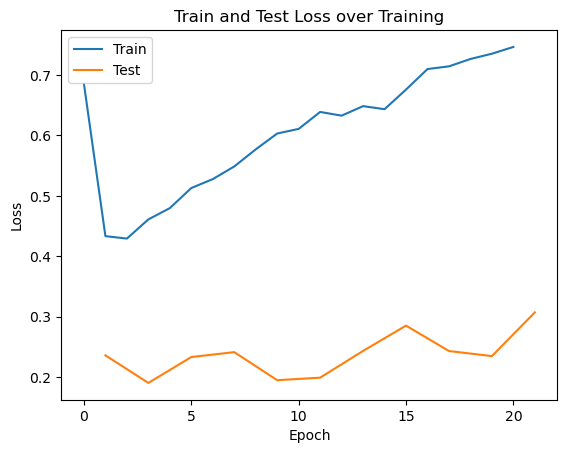

In [ ]:
if TRAIN_DROPOUT_MODEL:
    plt.plot(np.arange(n_epochs + 1), train_loss_drop, label="Train")
    plt.plot(np.arange(1, n_epochs + 2, 2), test_loss_drop, label="Test")
    plt.title("Train and Test Loss over Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()


The dropout layer works by randomly deactivating certain neurons in the linear layers (or if applied to the input, deactivating certain features of the input vector). In this way the training load is more evenly distributed among the network, encourages diversity in the learned parameters and helps reduce redundancy i.e. neurons that do not significantly contribute to the performance of the network (cause of their existance can be attributed to overparametrization; see https://arxiv.org/abs/1503.02531, https://arxiv.org/abs/1803.03635).

In our implementation we use all the neurons for the testing to get the best accuracy, so in this sense this is Inverted Dropout not dropout. See: https://stackoverflow.com/questions/54109617/implementing-dropout-from-scratch

In [ ]:
if TRAIN_DROPOUT_MODEL and TRAIN_BASE_MODEL:
    ## test error comparation
    print("With dropout: {}".format(test_loss_drop[-1]))
    print("Without dropout: {}".format(test_loss[-1]))


With dropout: 0.30725320733553085
Without dropout: 0.4533351769449194


#### Parametric Relu

In [ ]:
def PRelu(X,a):
    assert X.shape == a.shape

    return torch.where(X > 0, X, a*X)

# define the neural network
def prelu_model(x, w_h, w_h2, w_o, a1, a2):
    h = PRelu(x @ w_h,a1)
    h2 = PRelu(h @ w_h2, a2)
    pre_softmax = h2 @ w_o
    return pre_softmax

In [ ]:
if TRAIN_PRELU_MODEL:
    # initialize weights
    # input shape is (B, 784)
    w_h_prelu = init_weights((784, 625))
    a1 = init_weights((batch_size,625))
    # hidden layer with 625 neurons
    w_h2_prelu = init_weights((625, 625))
    a2 = init_weights((batch_size,625))
    # hidden layer with 625 neurons
    w_o_prelu = init_weights((625, 10))
    # output shape is (B, 10)

    optimizer = RMSprop(params=[w_h_prelu, w_h2_prelu, w_o_prelu,a1,a2])

    train_loss_prelu = []
    test_loss_prelu = []

In [ ]:
if TRAIN_PRELU_MODEL:
    # put this into a training loop over 100 epochs
    for epoch in range(n_epochs + 1):
        train_loss_this_epoch = []
        for idx, batch in enumerate(train_dataloader):
            x, y = batch

            # our model requires flattened input
            x = x.reshape(batch_size, 784).to(device)
            # feed input through model
            noise_py_x = prelu_model(x, w_h_prelu, w_h2_prelu, w_o_prelu,a1,a2)

            # reset the gradient
            optimizer.zero_grad()

            # the cross-entropy loss function already contains the softmax
            loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")

            train_loss_this_epoch.append(float(loss))

            # compute the gradient
            loss.backward()
            # update weights
            optimizer.step()

        train_loss_prelu.append(np.mean(train_loss_this_epoch))

        # test periodically
        if epoch % 2 == 0:
            print(f"Epoch: {epoch}")
            print(f"Mean Train Loss: {train_loss_prelu[-1]:.2e}")
            test_loss_this_epoch = []

            # no need to compute gradients for validation
            with torch.no_grad():
                for idx, batch in enumerate(test_dataloader):
                    x, y = batch
                    x = x.reshape(batch_size, 784).to(device)
                    noise_py_x = prelu_model(x, w_h_prelu, w_h2_prelu, w_o_prelu,a1,a2)

                    loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")
                    test_loss_this_epoch.append(float(loss))

            test_loss_prelu.append(np.mean(test_loss_this_epoch))

            print(f"Mean Test Loss:  {test_loss_prelu[-1]:.2e}")



KeyboardInterrupt: 

In [ ]:
if TRAIN_PRELU_MODEL:
    plt.plot(np.arange(n_epochs + 1), train_loss_prelu, label="Train")
    plt.plot(np.arange(1, n_epochs + 2, 2), test_loss_prelu, label="Test")
    plt.title("Train and Test Loss over Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()


#### Convolutional layers

In [ ]:
if TRAIN_LENET:
    hyperparams = {
        'length': 3,
        'f': [32,64,128],
        'pic_in': [1,32,64],
        'k_x': [5,5,3],
        'k_y': [5,5,3]
    }

    weight_vectors = [init_weights((hyperparams['f'][i],hyperparams['pic_in'][i],hyperparams['k_x'][i],hyperparams['k_y'][i])) for i in range(3)]

    number_of_output_pixel = 128 # chat gpt answer
    # hidden layer with 625 neurons
    w_h2 = init_weights((number_of_output_pixel, 625))
    # hidden layer with 625 neurons
    w_o = init_weights((625, 10))
    # output shape is (B, 10)

    optimizer = RMSprop(params=[w_h2,w_o,*weight_vectors])

    train_loss_lenet = []
    test_loss_lenet = []

In [ ]:
def leNet(X,weight_vectors,w_h2,w_o,p_drop_input):
    '''
    x: (batch,1,28,28)
    '''
    conv1 = rectify(conv2d(X,weight_vectors[0]))
    subsampling_layer = max_pool2d(conv1,(2,2))
    out_layer = dropout(subsampling_layer,p_drop_input)

    conv2 = rectify(conv2d(out_layer,weight_vectors[1]))
    subsampling_layer_2 = max_pool2d(conv2,(2,2))
    out_layer_2 = dropout(subsampling_layer_2,p_drop_input)

    conv3 = rectify(conv2d(out_layer_2,weight_vectors[2]))
    subsampling_layer_3 = max_pool2d(conv3,(2,2))
    out_layer_3 = dropout(subsampling_layer_3,p_drop_input)

    # print(out_layer_3.shape)

    flattened_out = out_layer_3.reshape(batch_size,-1)

    # print(flattened_out.shape)

    h2 = rectify(flattened_out @ w_h2)
    pre_softmax = h2 @ w_o

    return pre_softmax

In [ ]:
def plot_lenet(image,filters):
    '''
    plots:
    - original test image
    - image after 3 filters from the conv1 applied to it (in parallel)
    - filter weights as images
    '''
    # Perform convolution using the selected filters
    conv_results = []
    for i in range(3):
        conv_result = conv2d(image.unsqueeze(0), filters[i].unsqueeze(0))
        conv_results.append(conv_result.cpu().squeeze().detach().numpy())

    # Convert the image and filters to numpy arrays for plotting
    image_np = image.cpu().squeeze().numpy()
    filters_np = filters.detach().cpu().squeeze().numpy()

    print(filters_np.shape)

    # Plot the results
    fig, axs = plt.subplots(3, 3, figsize=(12, 12))


    # Plot the filter weights and convolved images
    for i in range(3):
        # Plot the original image
        axs[i, 0].imshow(image_np, cmap='gray')
        axs[i, 0].set_title("Original Image")


        # Plot filter weights
        axs[i, 1].imshow(filters_np[i], cmap='viridis')
        axs[i, 1].set_title(f"Filter {i + 1} Weights")

        # Plot convolved image
        axs[i, 2].imshow(conv_results[i], cmap='viridis')
        axs[i, 2].set_title(f"Convolution with Filter {i + 1}")

    plt.tight_layout()
    plt.show()

    

In [ ]:
if TRAIN_LENET:
    # put this into a training loop over 100 epochs
    for epoch in range(n_epochs + 1):
        train_loss_this_epoch = []
        for idx, batch in enumerate(train_dataloader):
            x, y = batch

            # our model requires flattened input
            x = x.to(device)
            # feed input through model
            noise_py_x = leNet(x,weight_vectors,w_h2,w_o,0.5)

            # reset the gradient
            optimizer.zero_grad()

            # the cross-entropy loss function already contains the softmax
            loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")

            train_loss_this_epoch.append(float(loss))

            # compute the gradient
            loss.backward()
            # update weights
            optimizer.step()

        train_loss_lenet.append(np.mean(train_loss_this_epoch))

        # test periodically
        if epoch % 2 == 0:
            print(f"Epoch: {epoch}")
            print(f"Mean Train Loss: {train_loss_lenet[-1]:.2e}")
            test_loss_this_epoch = []

            # no need to compute gradients for validation
            with torch.no_grad():
                for idx, batch in enumerate(test_dataloader):
                    x, y = batch
                    x = x.to(device)
                    noise_py_x = leNet(x,weight_vectors,w_h2,w_o,0)

                    loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")
                    test_loss_this_epoch.append(float(loss))

            test_loss_lenet.append(np.mean(test_loss_this_epoch))

            print(f"Mean Test Loss:  {test_loss_lenet[-1]:.2e}")



In [ ]:
if TRAIN_LENET:
    plt.plot(np.arange(n_epochs + 1), train_loss_lenet, label="Train")
    plt.plot(np.arange(1, n_epochs + 2, 2), test_loss_lenet, label="Test")
    plt.title("Train and Test Loss over Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()


In [ ]:
if TRAIN_LENET:
    data_iter = iter(test_dataloader)
    images, labels = next(data_iter)

    image = images[25]
    filters = weight_vectors[0][:3]

    plot_lenet(image.to(device),filters)

#### 4.2: Applying a random linear shift to the training images

In [ ]:
class RandomLinearShift(object):
    def __init__(self, shift_range=(-0.5, 0.5)):
        self.shift_range = shift_range

    def __call__(self, tensor):
        shift = np.random.uniform(self.shift_range[0], self.shift_range[1])
        return tensor + shift

    def __repr__(self):
        return self.__class__.__name__ + f'(shift_range={self.shift_range})'


In [ ]:

batch_size = 100

# transform images into normalized tensors
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))
])

transform_extended = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,)),
    RandomLinearShift(shift_range=(-0.5,0.5))
]) 

train_dataset = datasets.MNIST(
    "./",
    download=True,
    train=True,
    transform=transform,
)

test_dataset = datasets.MNIST(
    "./",
    download=True,
    train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
    ]),
)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
)

test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=1,
    pin_memory=True,
)

In [ ]:
if TRAIN_LENET_SHIFT:
    hyperparams = {
        'length': 3,
        'f': [32,64,128],
        'pic_in': [1,32,64],
        'k_x': [5,5,3],
        'k_y': [5,5,3]
    }

    weight_vectors = [init_weights((hyperparams['f'][i],hyperparams['pic_in'][i],hyperparams['k_x'][i],hyperparams['k_y'][i])) for i in range(3)]

    number_of_output_pixel = 128 # chat gpt answer
    # hidden layer with 625 neurons
    w_h2 = init_weights((number_of_output_pixel, 625))
    # hidden layer with 625 neurons
    w_o = init_weights((625, 10))
    # output shape is (B, 10)

    optimizer = RMSprop(params=[w_h2,w_o,*weight_vectors])

    train_loss_lenet_shift = []
    test_loss_lenet_shift = []

In [ ]:
if TRAIN_LENET_SHIFT:
    # put this into a training loop over 100 epochs
    for epoch in range(n_epochs + 1):
        train_loss_this_epoch = []
        for idx, batch in enumerate(train_dataloader):
            x, y = batch

            # our model requires flattened input
            x = x.to(device)
            # feed input through model
            noise_py_x = leNet(x,weight_vectors,w_h2,w_o,0.5)

            # reset the gradient
            optimizer.zero_grad()

            # the cross-entropy loss function already contains the softmax
            loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")

            train_loss_this_epoch.append(float(loss))

            # compute the gradient
            loss.backward()
            # update weights
            optimizer.step()

        train_loss_lenet_shift.append(np.mean(train_loss_this_epoch))

        # test periodically
        if epoch % 2 == 0:
            print(f"Epoch: {epoch}")
            print(f"Mean Train Loss: {train_loss_lenet_shift[-1]:.2e}")
            test_loss_this_epoch = []

            # no need to compute gradients for validation
            with torch.no_grad():
                for idx, batch in enumerate(test_dataloader):
                    x, y = batch
                    x = x.to(device)
                    noise_py_x = leNet(x,weight_vectors,w_h2,w_o,0.0)

                    loss = cross_entropy(noise_py_x, y.to(device), reduction="mean")
                    test_loss_this_epoch.append(float(loss))

            test_loss_lenet_shift.append(np.mean(test_loss_this_epoch))

            print(f"Mean Test Loss:  {test_loss_lenet_shift[-1]:.2e}")


In [ ]:
if TRAIN_LENET_SHIFT:
    plt.plot(np.arange(n_epochs + 1), train_loss_lenet_shift, label="Train")
    plt.plot(np.arange(1, n_epochs + 2, 2), test_loss_lenet_shift, label="Test")
    plt.title("Train and Test Loss over Training")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()


In [ ]:
if TRAIN_LENET_SHIFT:
    data_iter = iter(test_dataloader)
    images, labels = next(data_iter)

    image = images[25]
    filters = weight_vectors[0][:3]

    plot_lenet(image.to(device),filters)

#### Results table

In [ ]:
import pandas as pd

if ALL:

    data = {
        'architecture': ['base', 'dropout', 'prelu', 'lenet', 'lenet + shift'],
        'test_loss': [test_loss[-1],test_loss_drop[-1],test_loss_prelu[-1],test_loss_lenet[-1],test_loss_lenet_shift[-1]],
        'train_loss': [train_loss[-1],train_loss_drop[-1],train_loss_prelu[-1],train_loss_lenet[-1],train_loss_lenet_shift[-1]]
    }

    df = pd.DataFrame(data)

    print("Number of epochs: {}".format(n_epochs))
    print("Learning rate: {}".format(1e-3))
    print("Batch size {}".format(batch_size))
    print("Dropout rate (dropout model + lenet + lenet with shift) {}".format(0.5))
    print(df)

We observe that regularization techniques (dropout, random shift) help with overfitting.